# Real vs Fake Faces - Data Transformation

Basándonos en el análisis de los datos efectuado con anterioridad, en el presente notebook se procederá a aplicar determinadas transformaciones sobre el dataset de imágenes con el fin último de mejorar los procesos de entrenamiento de los modelos que se emplearán.

## Transformaciones

Se definirán una serie de transformaciones, que serán incluídas en una función determinada. Esa función luego será empleada como argumento en el constructor de una clase customizada que extiende de la clase abstracta "torch.utils.data.Dataset".

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics

Se procede con la creación de la clase customizada que será la responsable de representar el dataset.

In [2]:
class FacesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

Carga de los dataset de entrenamiento y validación.

In [3]:
train_df = pd.read_csv('../data/raw/train.csv')
valid_df = pd.read_csv('../data/raw/valid.csv')

### Normalización

Se buscará aplicar una normalización de las imágenes. Esta transformación normaliza los valores de píxel de la imagen. Esta transformación resta la media y luego divide por la desviación estándar para cada canal de color de la imagen.
La normalización es un paso importante en el preprocesamiento de datos para el entrenamiento de modelos ya que ayuda a estandarizar los datos de entrada y mejora la convergencia del modelo durante el entrenamiento.

Calcularemos en base al dataset de entrenamiento cuáles son los valores de media y desvío para cada canal.

In [4]:
# Define una transformación para convertir las imágenes a tensores para luego normalizarlas
# def calculus_transform(image) -> torch.Tensor:
#     transform = transforms.ToTensor()
#     return transform(image)

calculus_transform = transforms.ToTensor()


# Variables para calcular la media y la desviación estándar
mean = 0.
std = 0.
total_samples = 0

calculus_dataset = FacesDataset(dataframe=train_df, root_dir='../data/raw/', transform=calculus_transform)
# Crea un DataLoader para iterar sobre el conjunto de datos
calculus_loader = torch.utils.data.DataLoader(calculus_dataset, batch_size=1000, shuffle=True)


for images, _ in calculus_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

# Calcula la media y la desviación estándar finales
mean /= total_samples
std /= total_samples

print("Mean:", mean.numpy())
print("Std:", std.numpy())

Mean: [0.5212096  0.42598605 0.38105515]
Std: [0.24863924 0.22383371 0.22106402]


Con estos valores podremos definir una Normalización adecuada al dataset de entrenamiento.

### Resizing

Se aplicará un resizing para que el tamaño de entrada sea de (224,244). Esto nos permitirá emplear redes preentrenadas como AlexNet, DenseNet, Inception, ResNet, VGG entre otras

### Aplicación de las transformaciones

A continuación se procederá a aplicar estas dos transformaciones a los dataset.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy()),
])

In [6]:
# custom datasets
train_dataset = FacesDataset(dataframe=train_df, root_dir='../data/raw/', transform=transform)
valid_dataset = FacesDataset(dataframe=valid_df, root_dir='../data/raw/', transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

### Data Augmentation

Con el fin de mejorar la performance de nuestros modelos, se empleará data augmentation para aumentar la cantidad de imagenes en el dataset.

Cabe destacar que estas transformaciones referidas a data augmentation se hacen con carácter de prueba conceptual, ya que de requerir más entradas, lo lógico sería directamente tomar más imágenes del dataset padre con 140.000 imágenes.

1. Flip Horizontal: 
Se voltearán las imágenes de forma vertical, con una probabilidad de ocurrencia de p=0,5.

2. Color Jitter: 
Se modificará de forma aleatoria el brillo, contraste, saturación y HUE de la imagen.

### Aplicación de las transformaciones con Data Augmentation

A continuación se definirán y se aplicarán las transformaciones definidas.

In [7]:
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

Instanciación de los datasets custom de train y validación (FacesDataset) con sus respectivos DataLoaders y con la transformación.

In [8]:
# custom datasets
train_dataset_aug = FacesDataset(dataframe=train_df, root_dir='../data/raw/', transform=transform_aug)
valid_dataset_aug = FacesDataset(dataframe=valid_df, root_dir='../data/raw/', transform=transform)

# data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=32, shuffle=False)

Se realiza una comparación entre las imágenes a fin de visualizar el resultado de aplicar las transformaciones sobre el dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


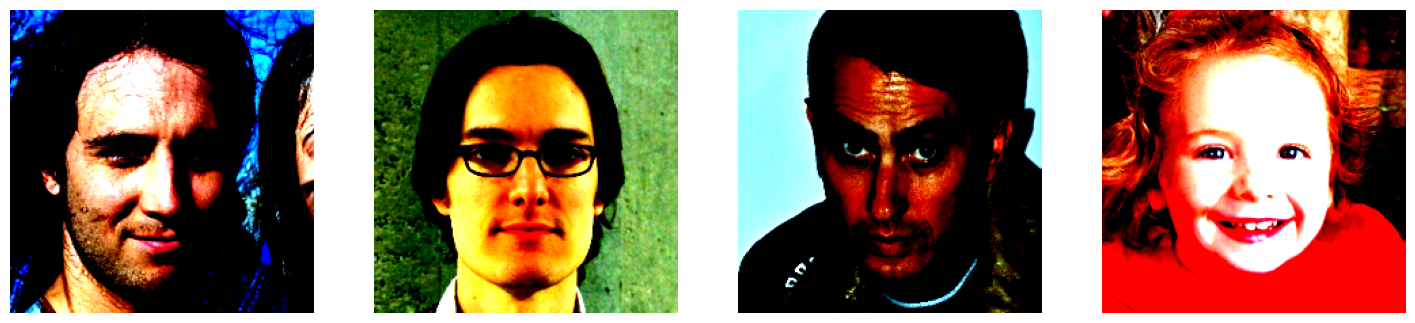

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


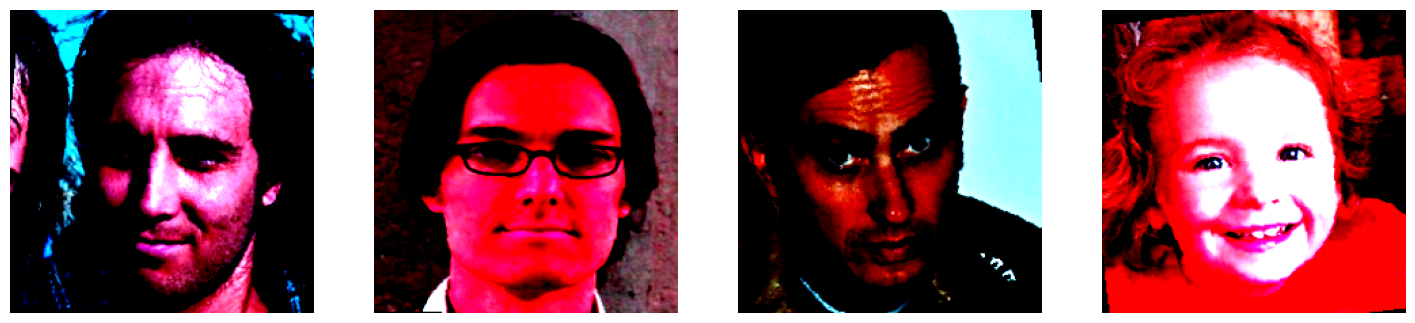

In [9]:
images_ids = np.random.randint(low=0, high=len(train_dataset), size=4)

# Ploteo las imagenes sin augmentacion
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for id, row in enumerate(rows):
    row.imshow(train_dataset[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for id, row in enumerate(rows):
    row.imshow(train_dataset_aug[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

## Prueba de las transformaciones

Se define un modelo sencillo a fin de ejecutar una pequeña prueba, con el objetivo verificar si el data augmentation beneficia el entrenamiento del modelo.

### Funciones

Declaración de la función de train y de un método que grafica el error de entrenamiento vs validación.

In [10]:
def train(model, optimizer, criterion, metric, data, epochs):

    train_loader = data["train"]
    valid_loader = data["valid"]

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target.float())
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target.float()).item()
            epoch_valid_accuracy += metric(output, valid_target.float()).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [11]:
def plot_history(history):
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_loss"])
    axs[0].plot(history["valid_loss"])
    axs[0].title.set_text('Error de Entrenamiento vs Validación')
    axs[0].legend(['Train', 'Valid'])

    axs[1].plot(history["train_acc"])
    axs[1].plot(history["valid_acc"])
    axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
    axs[1].legend(['Train', 'Valid'])

## Modelo de Prueba

Se propone el siguiente modelo de prueba como baseline para erificar si efectivamente el data augmentation trae beneficios durante el proceso de entrenamiento.

In [12]:
class FacesSimpleCNN(nn.Module):
    def __init__(self):
        super(FacesSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        # self.fc2 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.final = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.final(x)
        return x.squeeze()

In [13]:
# cantidad_clases = 2
images_width = 224
images_height = 224
simple_model = FacesSimpleCNN()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)
# loss = torch.nn.CrossEntropyLoss()
loss = torch.nn.BCELoss()
# metric = torchmetrics.Accuracy(task='multiclass', num_classes=cantidad_clases)
metric = torchmetrics.classification.BinaryAccuracy()
data = {"train": train_loader, "valid": valid_loader, "image_width": images_width, "image_height": images_height}

history = train(simple_model,
                optimizer,
                loss,
                metric,
                data,
                10)

Epoch: 1/10 - Train loss 0.628874 - Train Accuracy 0.644502 - Valid Loss 0.563662 - Valid Accuracy 0.707447
Epoch: 2/10 - Train loss 0.530437 - Train Accuracy 0.736301 - Valid Loss 0.515305 - Valid Accuracy 0.744348
Epoch: 3/10 - Train loss 0.451830 - Train Accuracy 0.796613 - Valid Loss 0.465328 - Valid Accuracy 0.791556
Epoch: 4/10 - Train loss 0.370318 - Train Accuracy 0.840991 - Valid Loss 0.424150 - Valid Accuracy 0.809508
Epoch: 5/10 - Train loss 0.305624 - Train Accuracy 0.876142 - Valid Loss 0.431490 - Valid Accuracy 0.807624
Epoch: 6/10 - Train loss 0.232644 - Train Accuracy 0.909722 - Valid Loss 0.393757 - Valid Accuracy 0.819814
Epoch: 7/10 - Train loss 0.176976 - Train Accuracy 0.936358 - Valid Loss 0.450531 - Valid Accuracy 0.810284
Epoch: 8/10 - Train loss 0.136568 - Train Accuracy 0.952768 - Valid Loss 0.448991 - Valid Accuracy 0.827238
Epoch: 9/10 - Train loss 0.094195 - Train Accuracy 0.968607 - Valid Loss 0.488998 - Valid Accuracy 0.822584
Epoch: 10/10 - Train loss 0.

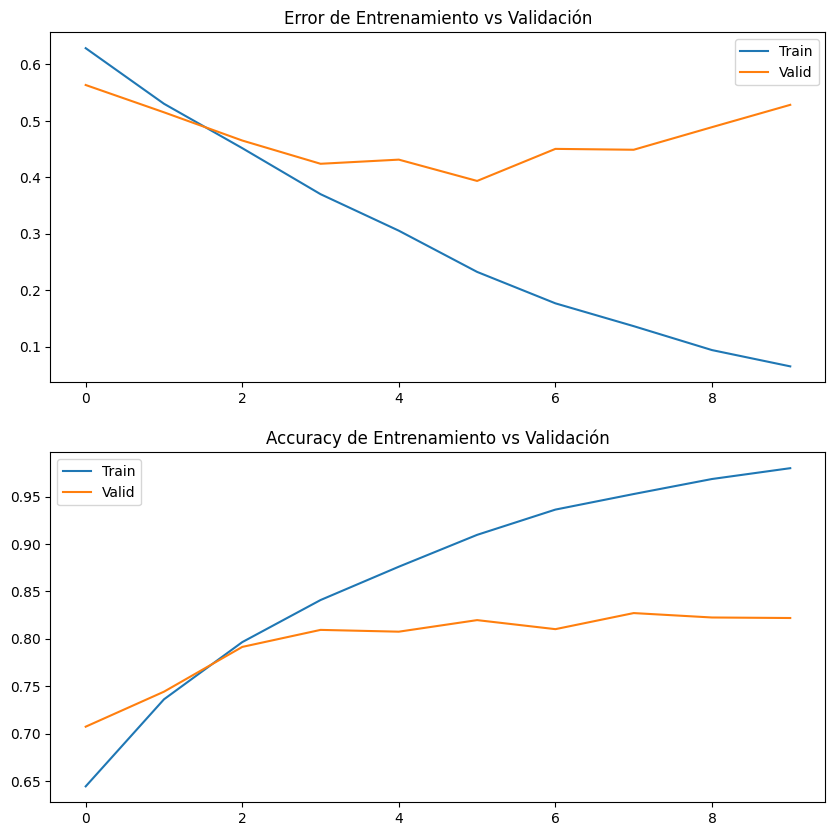

In [14]:
plot_history(history)

A continuación se realiza el mismo entrenamiento pero empleando el dataset aumentado.

In [15]:
# cantidad_clases = 2
images_width = 224
images_height = 224
simple_model_aug = FacesSimpleCNN()
optimizer_aug = torch.optim.Adam(simple_model_aug.parameters(), lr=0.0001)
# loss_aug = torch.nn.CrossEntropyLoss()
loss_aug = torch.nn.BCELoss()
# metric_aug = torchmetrics.Accuracy(task='multiclass', num_classes=cantidad_clases)
metric_aug = torchmetrics.classification.BinaryAccuracy()
data_aug = {"train": train_loader_aug, "valid": valid_loader_aug, "image_width": images_width, "image_height": images_height}

history_aug = train(simple_model_aug,
                optimizer_aug,
                loss_aug,
                metric_aug,
                data_aug,
                25)

Epoch: 1/25 - Train loss 0.673775 - Train Accuracy 0.584094 - Valid Loss 0.633944 - Valid Accuracy 0.651707
Epoch: 2/25 - Train loss 0.638068 - Train Accuracy 0.636273 - Valid Loss 0.619140 - Valid Accuracy 0.651817
Epoch: 3/25 - Train loss 0.620593 - Train Accuracy 0.660816 - Valid Loss 0.593014 - Valid Accuracy 0.696144
Epoch: 4/25 - Train loss 0.607002 - Train Accuracy 0.679890 - Valid Loss 0.588318 - Valid Accuracy 0.679965
Epoch: 5/25 - Train loss 0.595005 - Train Accuracy 0.683267 - Valid Loss 0.563922 - Valid Accuracy 0.711547
Epoch: 6/25 - Train loss 0.581955 - Train Accuracy 0.698773 - Valid Loss 0.555974 - Valid Accuracy 0.721188
Epoch: 7/25 - Train loss 0.566319 - Train Accuracy 0.704766 - Valid Loss 0.579560 - Valid Accuracy 0.691157
Epoch: 8/25 - Train loss 0.555310 - Train Accuracy 0.715468 - Valid Loss 0.539796 - Valid Accuracy 0.730940
Epoch: 9/25 - Train loss 0.534062 - Train Accuracy 0.735921 - Valid Loss 0.553654 - Valid Accuracy 0.716534
Epoch: 10/25 - Train loss 0.

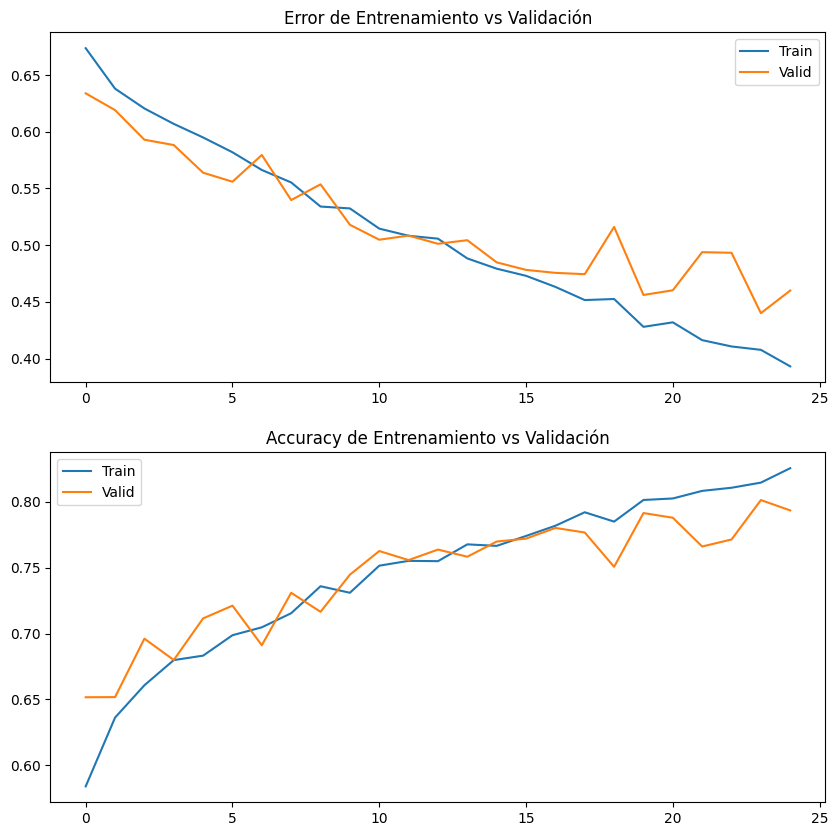

In [16]:
plot_history(history_aug)

In [ ]:
# Se guardan los modelos en disco
torch.save(simple_model_aug.state_dict(), '../models/notebook-simple_model_aug.pth')
torch.save(simple_model.state_dict(), '../models/notebook-simple_model.pth')

## Conclusiones

Al aplicar data augmentation, se logró mayor estabilidad durante el entrenamiento. Esto se puede observar fácilmente en los gráficos de "Error y Accuracy de Entrenamiento vs Validación"